In [13]:
import logging
import pypsa
import linopy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

logging.basicConfig(level=logging.ERROR)
pypsa.optimization.optimize.logger.setLevel(logging.ERROR)
pypsa.consistency.logger.setLevel(logging.ERROR)
linopy.model.logger.setLevel(logging.ERROR)
linopy.io.logger.setLevel(logging.ERROR)
linopy.constants.logger.setLevel(logging.ERROR)

%matplotlib inline



In [135]:
# power is purchased from generators to satisfy loads
# p_nom is consumed until load is satisfied, the final generation needed becomes the marginal cost
# p_nom_extendable allows the marginal cost to be purchased by adding generators
# the marginal price is available on the bus
# a price sensitive load can be created with a Generator by setting p_min_pu = -1, p_max_pu = 0, and a marginal_cost

In [30]:


n1 = pypsa.Network()
n1.set_snapshots(range(5))

n1.add("Bus", "grid")

n1.add("Load", "load", bus="grid", p_set=[100, 100, 140, 100, 100])

n1.add("Generator", "coal", bus="grid", p_nom=100, marginal_cost=30)
n1.add("Generator", "gas", bus="grid", p_nom=100, marginal_cost=100)

n1.add("Bus", "battery")

n1.add("Store", "battery", bus="battery", e_nom=100, e_max=100, e_min=0, e_initial=50, marginal_cost=10)

n1.add("Link", "battery_to_grid", bus0="battery", bus1="grid", p_nom=100)

n1.optimize()

n1.buses_t.marginal_price


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-wfxsnz8d has 55 rows; 25 cols; 79 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+01, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [5e+01, 1e+02]
Presolving model
9 rows, 15 cols, 23 nonzeros  0s
0 rows, 1 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-55); columns 0(-25); elements 0(-79) - Reduced to empty
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-wfxsnz8d
Model status        : Optimal
Objective value     :  1.5200000000e+04
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/linopy-solve-8pp6mvb_.sol


Bus,grid,battery
snapshot,,
0,30.0,30.0
1,30.0,30.0
2,30.0,30.0
3,30.0,30.0
4,30.0,30.0


In [26]:
n1.generators_t.p

Generator,coal,gas
snapshot,,
0,100.0,-0.0
1,100.0,-0.0
2,100.0,-0.0
3,100.0,-0.0
4,100.0,-0.0


In [27]:
n1.stores_t.e

Store,battery
snapshot,
0,50.0
1,50.0
2,-0.0
3,-0.0
4,-0.0


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-8ze_8ono has 312 rows; 144 cols; 479 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+01, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [2e+00, 1e+02]
Presolving model
38 rows, 70 cols, 99 nonzeros  0s
12 rows, 36 cols, 47 nonzeros  0s
7 rows, 31 cols, 37 nonzeros  0s
3 rows, 27 cols, 29 nonzeros  0s
2 rows, 5 cols, 6 nonzeros  0s
0 rows, 1 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-312); columns 0(-144); elements 0(-479) - Reduced to empty
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-8ze_8ono
Model status        : Optimal
Objective value     :  1.8450000000e+04
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/linopy-solve-1na6z0dv.sol


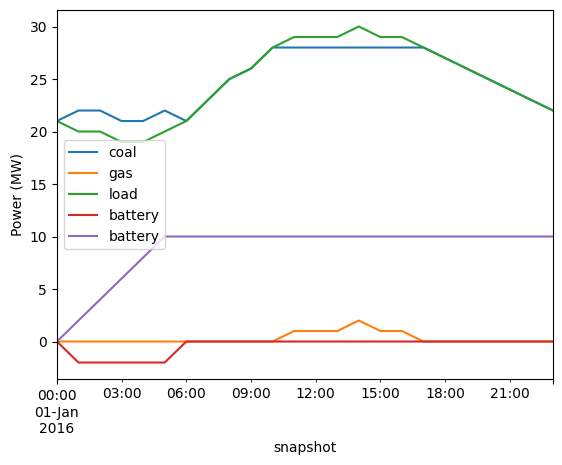

In [74]:
single_day_hourly = pd.date_range("2016-01-01 00:00", "2016-01-01 23:00", freq="h")    
index = single_day_hourly


demand = pd.Series([
    21, 20, 20, 19,
    19, 20, 21, 23,
    25, 26, 28, 29,
    29, 29, 30, 29,
    29, 28, 27, 26,
    25, 24, 23, 22
    ], index)

n2 = pypsa.Network()
n2.set_snapshots(index)

n2.add("Bus", "grid")

n2.add("Load", "load", bus="grid", p_set=demand)

n2.add("Generator", "coal", bus="grid", p_nom=28, marginal_cost=30)
n2.add("Generator", "gas", bus="grid", p_nom=100, marginal_cost=100)

n2.add("Bus", "battery")

battery_e_min_pu = pd.Series(
    [0] * 23 + [1]
    , index)

n2.add("Store", "battery",
       bus="battery", e_nom=10, e_initial=0, marginal_cost=10,
       e_min_pu=battery_e_min_pu
       )

n2.add("Link", "battery_to_grid", bus0="battery", bus1="grid", p_nom=0)

n2.add("Link", "grid_to_battery", bus0="grid", bus1="battery", p_nom=2)

n2.optimize()

# n2.stores_t.e

fig, ax = plt.subplots()

(n2.generators_t.p).plot(ax=ax)
n2.loads_t.p_set.plot(ax=ax)
n2.stores_t.p.plot(ax=ax)
n2.stores_t.e.plot(ax=ax)

ax.set_ylabel("Power (MW)")
ax.get_legend().set_title("")

Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-lp9e4213 has 408 rows; 192 cols; 623 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+01, 2e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+00, 1e+02]
Presolving model
70 rows, 177 cols, 270 nonzeros  0s
48 rows, 155 cols, 226 nonzeros  0s
Dependent equations search running on 46 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
46 rows, 129 cols, 174 nonzeros  0s
Presolve : Reductions: rows 46(-362); columns 129(-63); elements 174(-449)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.0000000650e+02 Pr: 46(602) 0s
         65     1.8900000000e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-lp9e4213
Model status        : Optimal
Simplex   iter

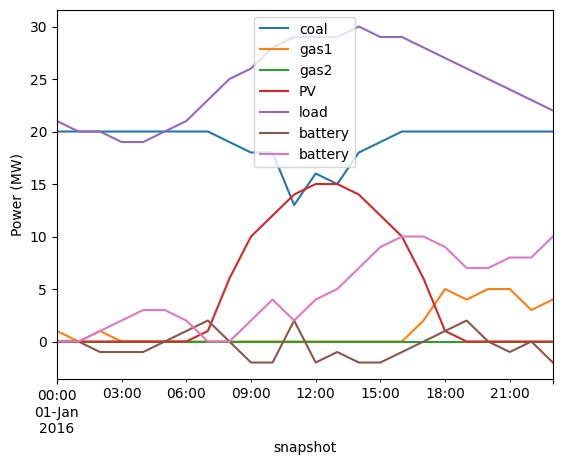

In [102]:
solar_pv = pd.Series(
    [0] * 7 + [1] +
    [6] + [10] + [12] + [14] +
    [15] + [15] + [14] + [12] +
    [10] + [6] + [1] +
    [0] * 5,
    index
)

n3 = pypsa.Network()
n3.set_snapshots(index)

n3.add("Carrier", "electricity", color="black")

n3.add("Bus", "grid", carrier="electricity")

n3.add("Load", "load", bus="grid", p_set=demand)

n3.add("Generator", "coal", bus="grid", p_nom=20, marginal_cost=30)
n3.add("Generator", "gas1", bus="grid", p_nom=5, marginal_cost=100)
n3.add("Generator", "gas2", bus="grid", p_nom=100, marginal_cost=150)

n3.add("Generator", "PV", bus="grid", p_nom=1, p_max_pu=solar_pv, marginal_cost=20)


n3.add("Bus", "battery", carrier="electricity")

battery_e_min_pu = pd.Series(
    [0] * 23 + [1]
    , index)

n3.add("Store", "battery", carrier="electricity",
       bus="battery", e_nom=10, e_initial=0, marginal_cost=10,
       e_min_pu=battery_e_min_pu
       )

n3.add("Link", "battery_to_grid", bus0="battery", bus1="grid", p_nom=2)

n3.add("Link", "grid_to_battery", bus0="grid", bus1="battery", p_nom=2)

n3.optimize()

# n3.stores_t.e

fig, ax = plt.subplots()

(n3.generators_t.p).plot(ax=ax)
n3.loads_t.p_set.plot(ax=ax)
n3.stores_t.p.plot(ax=ax)
n3.stores_t.e.plot(ax=ax)

ax.set_ylabel("Power (MW)")
ax.get_legend().set_title("")

In [91]:
tsc = (
    pd.concat([n3.statistics.capex(), n3.statistics.opex()], axis=1).sum(axis=1)#.div(1e9)
)
optimal_cost = tsc.sum()
tsc

n3.statistics.opex().sum()

np.float64(18900.0)

(<Figure size 718.875x300 with 1 Axes>,
 <Axes: xlabel='snapshot', ylabel='Energy Balance []'>,
 <seaborn.axisgrid.FacetGrid at 0x1182417f0>)

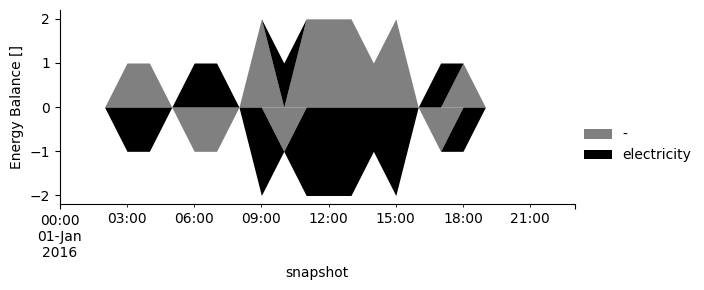

In [92]:
n3.statistics.energy_balance.plot.area(linewidth=0, bus_carrier="electricity")

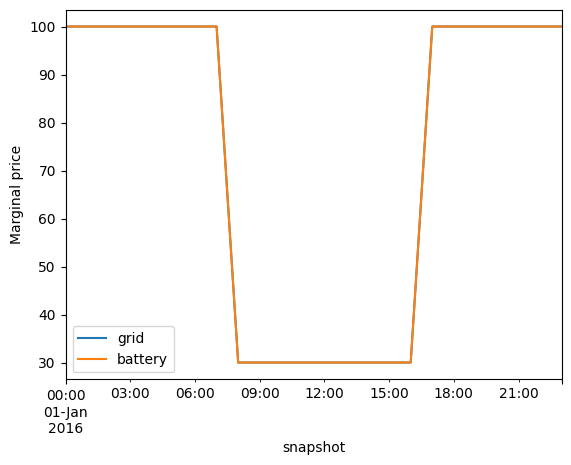

In [103]:
fig, ax = plt.subplots()

(n3.buses_t.marginal_price).plot(ax=ax)

ax.set_ylabel("Marginal price")
ax.get_legend().set_title("")

In [58]:
n2.stores_t.p

Store,battery
snapshot,
2016-01-01 00:00:00,-0.0
2016-01-01 01:00:00,-8.0
2016-01-01 02:00:00,-2.0
2016-01-01 03:00:00,10.0
2016-01-01 04:00:00,-0.0
2016-01-01 05:00:00,-0.0
2016-01-01 06:00:00,-5.0
2016-01-01 07:00:00,-5.0
2016-01-01 08:00:00,6.0


In [57]:
n2.generators_t.p

Generator,coal,gas
snapshot,,
2016-01-01 00:00:00,21.0,-0.0
2016-01-01 01:00:00,28.0,-0.0
2016-01-01 02:00:00,22.0,-0.0
2016-01-01 03:00:00,9.0,-0.0
2016-01-01 04:00:00,19.0,-0.0
2016-01-01 05:00:00,20.0,-0.0
2016-01-01 06:00:00,26.0,-0.0
2016-01-01 07:00:00,28.0,-0.0
2016-01-01 08:00:00,19.0,-0.0


In [53]:

n2.buses_t.marginal_price

Store,battery
snapshot,
2016-01-01 00:00:00,10.0
2016-01-01 01:00:00,10.0
2016-01-01 02:00:00,10.0
2016-01-01 03:00:00,10.0
2016-01-01 04:00:00,10.0
2016-01-01 05:00:00,10.0
2016-01-01 06:00:00,10.0
2016-01-01 07:00:00,10.0
2016-01-01 08:00:00,10.0


In [136]:
marginal_costs = {"Wind": 0, "Hydro": 0, "Coal": 30, "Gas": 60, "Oil": 80}

# power plant capacities (nominal powers in MW) in each country (not necessarily realistic)
power_plant_p_nom = {
    "South Africa": {"Coal": 35000, "Wind": 3000, "Gas": 8000, "Oil": 2000},
    "Mozambique": {
        "Hydro": 1200,
    },
    "Swaziland": {
        "Hydro": 600,
    },
}

# transmission capacities in MW (not necessarily realistic)
transmission = {
    "South Africa": {"Mozambique": 500, "Swaziland": 250},
    "Mozambique": {"Swaziland": 100},
}

# country electrical loads in MW (not necessarily realistic)
loads = {"South Africa": 42000, "Mozambique": 650, "Swaziland": 250}


country = "South Africa"

network = pypsa.Network()

# snapshots labelled by [0,1,2,3]
network.set_snapshots(range(4))

network.add("Bus", country)

# p_max_pu is variable for wind
for tech in power_plant_p_nom[country]:
    network.add(
        "Generator",
        f"{country} {tech}",
        bus=country,
        p_nom=power_plant_p_nom[country][tech],
        marginal_cost=marginal_costs[tech],
        p_max_pu=([0.3, 0.6, 0.4, 0.5] if tech == "Wind" else 1),
    )

# load which varies over the snapshots
network.add(
    "Load",
    f"{country} load",
    bus=country,
    p_set=loads[country] + np.array([0, 1000, 3000, 4000]),
)

# storage unit to do price arbitrage
network.add(
    "StorageUnit",
    f"{country} pumped hydro",
    bus=country,
    p_nom=1000,
    max_hours=6,  # energy storage in terms of hours at full power
    state_of_charge_set=pd.Series([np.nan, np.nan, 100, np.nan])
)

In [137]:

# import sys
# from pathlib import Path
# sys.path.append(str(Path.cwd().parent))
# from gridsim_backend.app.network import get_single_node_network

# n = get_single_node_network()

# n.plot()



In [138]:
import logging

logging.basicConfig(level=logging.DEBUG)

pypsa.optimization.optimize.logger.setLevel(logging.DEBUG)

network.optimize()
# print('objective', network.objective)
# print('statistics', network.statistics())
network.storage_units_t.p

Index(['South Africa'], dtype='object', name='Bus')
Index(['South Africa'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.solvers:Log file at /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 28 primals, 65 duals
Objective: 6.06e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-state_of_charge_set, StorageUnit-energy_balance were not assigned to the network.


Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [3e+01, 8e+01]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 5e+04]
Presolving model
8 rows, 23 cols, 33 nonzeros  0s
1 rows, 4 cols, 3 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-65); columns 0(-28); elements 0(-96) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  6.0640000000e+06
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/linopy-solve-tf51msrs.sol


StorageUnit,South Africa pumped hydro
snapshot,
0,-100.0
1,-1000.0
2,1000.0
3,100.0


In [139]:
df = pd.DataFrame(
    {attr: n.stores_t[attr]["battery storage"] for attr in ["p", "e"]}
)
df.plot(grid=True, figsize=(20, 10))
plt.legend(labels=["Energy output", "State of charge"])
plt.tight_layout()

KeyError: 'battery storage'

In [24]:
n.stores_t

{'e_min_pu': Empty DataFrame
 Columns: []
 Index: [2025-03-01 00:00:00, 2025-03-01 00:05:00, 2025-03-01 00:10:00, 2025-03-01 00:15:00, 2025-03-01 00:20:00, 2025-03-01 00:25:00, 2025-03-01 00:30:00, 2025-03-01 00:35:00, 2025-03-01 00:40:00, 2025-03-01 00:45:00, 2025-03-01 00:50:00, 2025-03-01 00:55:00, 2025-03-01 01:00:00, 2025-03-01 01:05:00, 2025-03-01 01:10:00, 2025-03-01 01:15:00, 2025-03-01 01:20:00, 2025-03-01 01:25:00, 2025-03-01 01:30:00, 2025-03-01 01:35:00, 2025-03-01 01:40:00, 2025-03-01 01:45:00, 2025-03-01 01:50:00, 2025-03-01 01:55:00, 2025-03-01 02:00:00, 2025-03-01 02:05:00, 2025-03-01 02:10:00, 2025-03-01 02:15:00, 2025-03-01 02:20:00, 2025-03-01 02:25:00, 2025-03-01 02:30:00, 2025-03-01 02:35:00, 2025-03-01 02:40:00, 2025-03-01 02:45:00, 2025-03-01 02:50:00, 2025-03-01 02:55:00, 2025-03-01 03:00:00, 2025-03-01 03:05:00, 2025-03-01 03:10:00, 2025-03-01 03:15:00, 2025-03-01 03:20:00, 2025-03-01 03:25:00, 2025-03-01 03:30:00, 2025-03-01 03:35:00, 2025-03-01 03:40:00, 2025